In [1]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import logsumexp

/Users/cswa648/envs/python36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/cswa648/envs/python36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/cswa648/envs/python36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/cswa648/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
n = 100
mu = 1.3
sd = 0.8
x = np.random.normal(mu, sd, size=n)

In [46]:
with pm.Model() as model:
    mu_ = pm.Normal('mu')
    sd_ = pm.HalfNormal('sd')
    x_ = pm.Normal('x', mu=mu_, sd=sd_, observed=x)
    
model

Average Loss = 583.47: 100%|██████████| 1000/1000 [00:00<00:00, 1843.01it/s]
Finished [100%]: Average Loss = 582.3


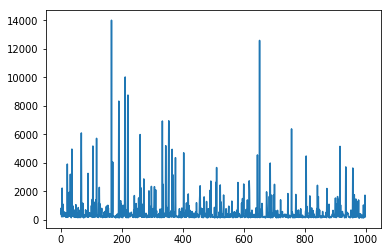

In [60]:
with model:
    fit = pm.fit(n=1000)

plt.plot(fit.hist)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3947.93draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3025c240>,
      dtype=object)

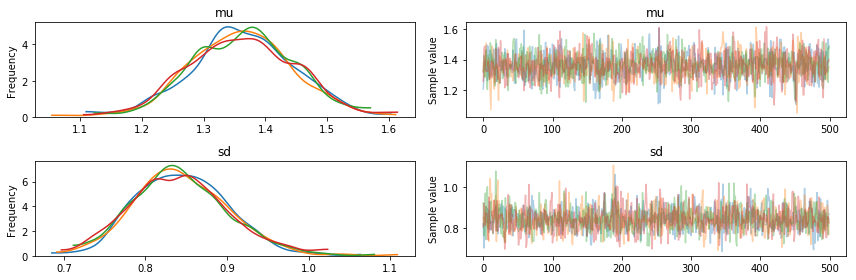

In [61]:
with model:
    trace = pm.sample()
    
pm.traceplot(trace)

(<matplotlib.axes._subplots.AxesSubplot at 0x1c3048aa20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c30407908>)

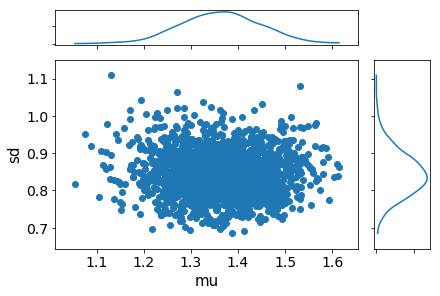

In [62]:
import arviz as az

inf_data = az.from_pymc3(trace=trace)
az.plot_joint(inf_data, var_names=['mu', 'sd'])

(<matplotlib.axes._subplots.AxesSubplot at 0x1c28097898>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2fc1f320>)

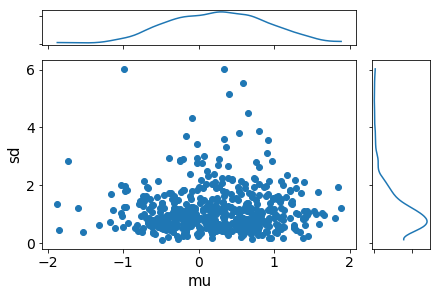

In [63]:
fit_trace = fit.sample()
inf_data_fit = az.from_pymc3(trace=fit_trace)
az.plot_joint(inf_data_fit, var_names=['mu', 'sd'])

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 7.000e+00,
        1.500e+01, 4.100e+01, 1.390e+02, 9.795e+03]),
 array([-1.82614954e+04, -1.64357006e+04, -1.46099058e+04, -1.27841110e+04,
        -1.09583162e+04, -9.13252137e+03, -7.30672657e+03, -5.48093177e+03,
        -3.65513697e+03, -1.82934216e+03, -3.54736018e+00]),
 <a list of 10 Patch objects>)

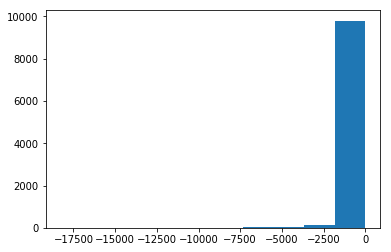

In [64]:
import theano
theano.config.compute_test_value = 'off'
log_weight = fit.sized_symbolic_logp - fit.symbolic_logq
n_samples = 10000
log_weights = fit.set_size_and_deterministic(log_weight, n_samples, False).eval()
log_weights_norm = log_weights - logsumexp(log_weights)
plt.hist(log_weights_norm)

In [65]:
def _psislw(lw, reff):
    n = len(lw)
    x = np.copy(lw, order='F')

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(n / 5., 3 * (n / reff) ** 0.5))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    k_min = 1. / 3

    # improve numerical accuracy
    x -= np.max(x)
    # sort the array
    x_sort_ind = np.argsort(x)
    # divide log weights into body and right tail
    xcutoff = max(x[x_sort_ind[cutoff_ind]], cutoffmin)

    expxcutoff = np.exp(xcutoff)
    tailinds, = np.where(x > xcutoff)
    x2 = x[tailinds]
    n2 = len(x2)
    if n2 <= 4:
        # not enough tail samples for gpdfit
        k = np.inf
    else:
        # order of tail samples
        x2si = np.argsort(x2)
        # fit generalized Pareto distribution to the right tail samples
        x2 = np.exp(x2) - expxcutoff
        k, sigma = pm.stats._gpdfit(x2[x2si])

    if k >= k_min and not np.isinf(k):
        # no smoothing if short tail or GPD fit failed
        # compute ordered statistic for the fit
        sti = np.arange(0.5, n2) / n2
        qq = _gpinv(sti, k, sigma)
        qq = np.log(qq + expxcutoff)
        # place the smoothed tail into the output array
        x[tailinds[x2si]] = qq
        # truncate smoothed values to the largest raw weight 0
        x[x > 0] = 0
    # renormalize weights
    x -= logsumexp(x)
    # store tail index k

    return x, k

smoothed_log_weights, k = _psislw(log_weights_norm, 1000)
smoothed_log_weights, k 

(array([-43.32454138, -57.80828263, -85.43072618, ..., -52.1982194 ,
        -67.39363487, -40.76590192]), -0.001835742389648054)